In [1]:
import os
os.chdir("..")
import scanpy as sc

import datapre as DP
from model import nn_model
import evaluation as eval

sc.set_figure_params(facecolor = "white")
sc.settings.verbosity = 1
dirname = "mouse_brain_sagittal_anterior"
NEIGHBOR_DIS = 1.0

In [2]:
adata = sc.datasets.visium_sge(sample_id = "V1_Mouse_Brain_Sagittal_Anterior")
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata, qc_vars = ["mt"], inplace = True)
sc.pp.filter_genes(adata, min_counts = 10)

/home/huggs/anaconda3/envs/rapids_nwt/lib/python3.8/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [3]:
DP.setup_seed(38)

In [4]:
DP.adata2seurat(adata, "V1_Mouse_Brain_Sagittal_Anterior")
! Rscript spagene.R V1_Mouse_Brain_Sagittal_Anterior 200
spagene = DP.find_spa("data/V1_Mouse_Brain_Sagittal_Anterior/spagene.txt")

Loading required package: ggplot2
Loading required package: patchwork


In [5]:
train_data, test_data, tt_data = DP.dataset_blind(adata, spagene, NEIGHBOR_DIS, neg_size = 200, mirror = True)

第0轮，训练损失：0.0379
第0轮，验证损失：0.0311
Validation loss decreased (inf --> 0.031116).  Saving model ...
第1轮，训练损失：0.0323
第1轮，验证损失：0.0281
Validation loss decreased (0.031116 --> 0.028087).  Saving model ...
第2轮，训练损失：0.0308
第2轮，验证损失：0.0279
Validation loss decreased (0.028087 --> 0.027937).  Saving model ...
第3轮，训练损失：0.0298
第3轮，验证损失：0.0274
Validation loss decreased (0.027937 --> 0.027396).  Saving model ...
第4轮，训练损失：0.0290
第4轮，验证损失：0.0269
Validation loss decreased (0.027396 --> 0.026865).  Saving model ...
第5轮，训练损失：0.0285
第5轮，验证损失：0.0263
Validation loss decreased (0.026865 --> 0.026347).  Saving model ...
第6轮，训练损失：0.0282
第6轮，验证损失：0.0262
Validation loss decreased (0.026347 --> 0.026157).  Saving model ...
第7轮，训练损失：0.0279
第7轮，验证损失：0.0279
EarlyStopping counter: 1 out of 7
第8轮，训练损失：0.0276
第8轮，验证损失：0.0265
EarlyStopping counter: 2 out of 7
第9轮，训练损失：0.0274
第9轮，验证损失：0.0257
Validation loss decreased (0.026157 --> 0.025653).  Saving model ...
第10轮，训练损失：0.0271
第10轮，验证损失：0.0273
EarlyStopping counter: 1 out of

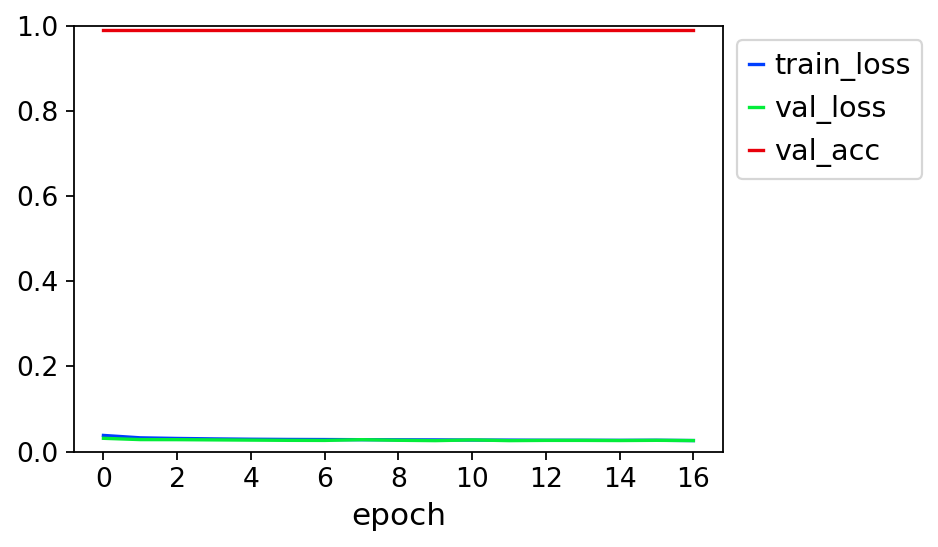

/data/huggs/nwt/SpaProx/evaluation.py:441: RuntimeWarning: invalid value encountered in long_scalars
  Precision = TP / (TP + FP)


{'Accuracy': 0.9978826271975502,
 'Precision': nan,
 'Recall': 0.0,
 'MCC': 0.0,
 'F1_Score': nan,
 'AUC': 0.9828794811687552,
 'Average Precision': 0.08312573920040257,
 'confusion_matrix': array([[144684,      0],
        [   307,      0]])}

In [6]:
nnmodel = nn_model.NeuralNetworkClassifier(
    batch_size = 128,
    hidden_layer_sizes = (500, 100),
    dropout_rate = 0.5
)
nnmodel.fit(train_data.feature, train_data.label)
predprob = nnmodel.predict_proba(test_data.feature)
eval.evaluate(test_data.label, predprob, verbose = False)

neg_size = 30 + class_weight = [1, 3]：0.045 + 0.958\
neg_size = 20 + class_weight = [1, 2]：0.046 + 0.929\
neg_size = 10 + class_weight = [1, 1]：0.044 + 0.915